In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [6]:
def true_fun(x, a=np.pi, b = 0, f=np.sin):
    x = np.atleast_1d(x)[:]
    a = np.atleast_1d(a)
    
    if f is None: f = lambda x:x # line
    
    x = np.sum([ai*np.power(x, i+1) for i,ai in enumerate(a)],axis=0)

    return f(x+b)

def noises(shape , noise_power):
    return np.random.randn(*shape) *noise_power

def dataset(a, b, f = None,  N = 250, x_max =1, noise_power = 0, random_x = True,  seed = 42):
    np.random.seed(seed)
    
    if random_x:
        x = np.sort(np.random.rand(N))*x_max    
    else:
        x = np.linspace(0,x_max,N)
    
    y_true = np.array([])
    
    for f_ in np.append([], f):
        y_true=np.append(y_true, true_fun(x, a, b, f_))
    
    y_true = y_true.reshape(-1,N).T
    y = y_true + noises(y_true.shape , noise_power)

    return np.squeeze(y), y_true, np.atleast_2d(x).T

def vis_data(y, y_true,x, title):
    fig  = plt.figure(figsize=(15,10))
    plt.scatter(x[:,0], y, edgecolor='b', label="Зашумленные Данные",s=196, alpha = 0.6)
    plt.scatter(x[:,0], y_true,label="Реальные Данные", s=81,c='g', alpha = 0.8)
    plt.grid()
    plt.xlabel('x',fontsize=35)
    plt.ylabel('y',fontsize=35)
    plt.legend(fontsize=25)
    plt.title(title, fontsize=25 )
    plt.xticks(fontsize = 25)
    plt.yticks(fontsize = 25);
    plt.tight_layout()


In [7]:
noise_power = 0.80

y, y_true, x = dataset(a = 5, b = 2,
                       f = None,  N = 250,
                       x_max =10, 
                       noise_power = noise_power,
                       seed = 42)

class LinearRegression():
    def __init__(self, 
                 X,
                 learning_rate = 0.5, 
                 epochs = 100,  
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000,
                 n_batches    = None,
                 random_state = 42):
        self.lr      = learning_rate
        self.epochs  = epochs
        self.weights = weights
        self.bias    = bias
        self.seed    = random_state
        self.batch_size = batch_size
        self.cost    = np.zeros(epochs)
        self.all_weights = []
        
        self.n_batches = n_batches
        
        if not(self.weights is None) and (self.bias):
            if self.weights.size == X.shape[1]:
                self.weights = np.append(self.bias,self.weights)
    
    #---------------------------------
    def forward(self, X):
        return np.dot(X, self.weights)
    
    #---------------------------------
    def loss(self, yhat, y):
        return np.square(yhat - y).sum()/y.size
    
    #---------------------------------
    def grad_step(self, yhat, y, X):
        return 2*np.dot(X.T, (yhat - y)) / y.size
    
    #---------------------------------
    def update(self):    
        return self.weights - self.lr*self.grad
    
    #---------------------------------
    def init(self, weights_size):
        np.random.seed(self.seed)
        return np.random.randn(weights_size)/np.sqrt(weights_size)
    
    #---------------------------------
    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        return yhat.squeeze()
    
    #---------------------------------
    def score(self, X, y):        
        yhat = self.predict(X)
        return 1-np.sum(np.square(y-yhat))/np.sum(np.square(y-np.mean(y)))
    
    #---------------------------------
    def fit(self, X, y):

        np.random.seed(self.seed)

        if self.weights is None:
            self.weights = self.init(X.shape[1])
        
        if self.bias is None: 
            self.bias    = self.init(1)
        
        if self.weights.size == X.shape[1]:
            self.weights = np.append(self.bias,self.weights)
        
        self.grad = np.zeros(self.weights.shape)
        self.cost = np.zeros(self.epochs)

        if self.batch_size is None:            
            self.batch_size = y.size
            
        if self.n_batches is None:
            self.n_batches = y.size//self.batch_size
            
        for i in range(self.epochs): 
            loss = 0
            for cnt,(x_batch, y_batch) in enumerate(self.load_batch(X,y)): 

                yhat         = self.forward(x_batch)
                self.grad    = self.grad_step(yhat,  y_batch, x_batch) 
                self.weights = self.update() 
                loss += self.loss(yhat,  y_batch)
                
                if cnt>= self.n_batches:
                    break
            self.cost[i] = loss/self.n_batches
        
        self.bias = self.weights[0]

    #---------------------------------
    def load_batch(self,X,y):
        idxs = np.arange(y.size)
        np.random.shuffle(idxs)

        for i_batch in range(0,y.size,self.batch_size):
            idx_batch = idxs[i_batch:i_batch+self.batch_size]
            x_batch   = np.take(X, idx_batch,axis=0)
            x_batch   = self.add_bias(x_batch)
            y_batch   = np.take(y, idx_batch)
            yield  x_batch, y_batch
    
    #---------------------------------
    def add_bias(self, X):
        return np.column_stack((np.ones(X.shape[0]), X))
    
    #---------------------------------
    def plot_cost(self, figsize = (12,6), title = ''):
        plt.figure(figsize = figsize)
        plt.plot(self.cost)
        plt.grid()
        plt.xlabel('Эпоха', fontsize = 24)
        plt.ylabel('Функция Потерь', fontsize = 24)
        plt.title(title, fontsize = 24)
        plt.show()
    
    #---------------------------------
    def get_w_and_b(self):
        return (self.weights[1:], self.bias)

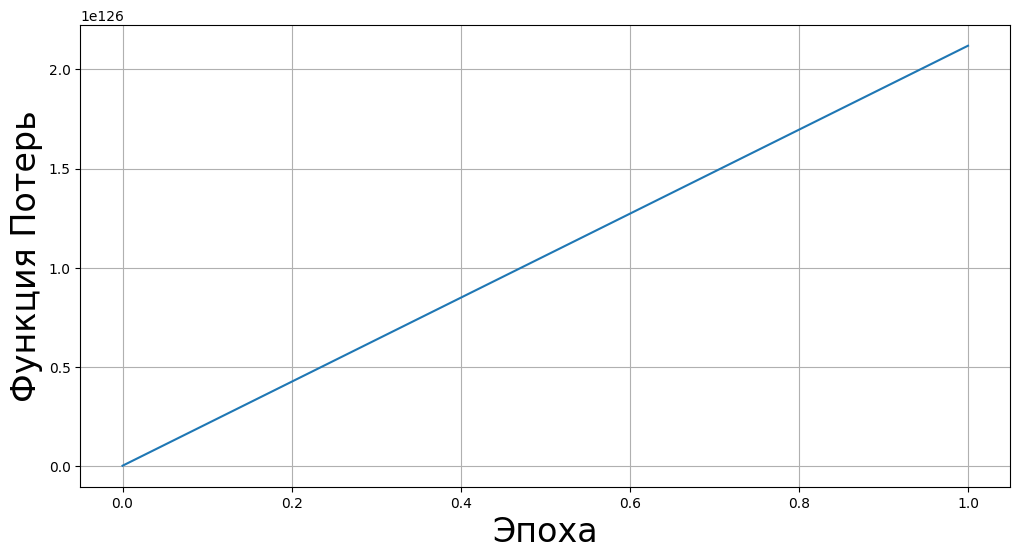

In [9]:
x_train, x_test = x[:200], x[200:]
y_train, y_test = y[:200], y[200:]
lin_reg_model = LinearRegression(X=x_train, batch_size=8, epochs=2)
lin_reg_model.fit(x_train, y_train)
lin_reg_model.plot_cost()
min_cost = min(lin_reg_model.cost)
rscore = lin_reg_model.score(x_train, y_train)
lin_reg_model.result1 = 0

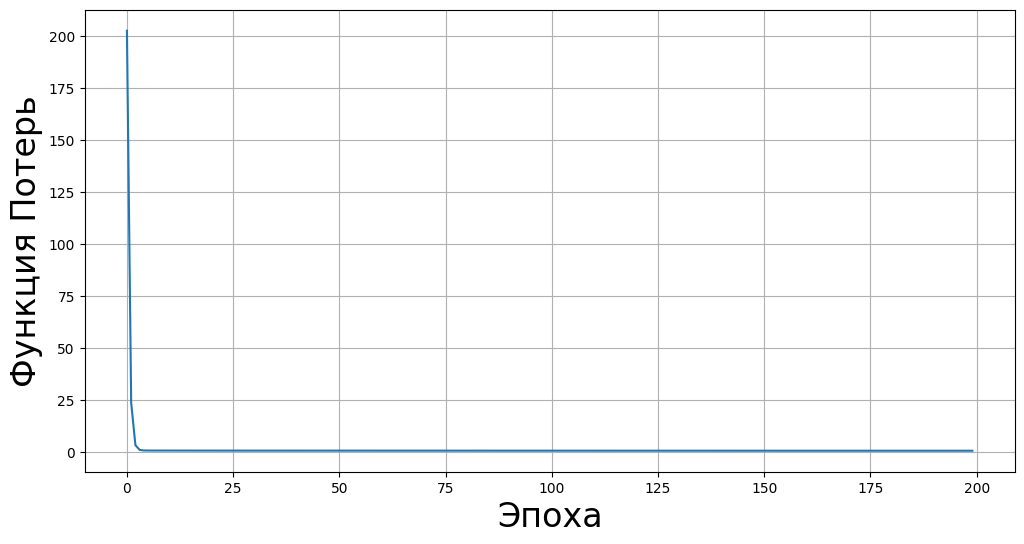

In [41]:
lin_reg_model = LinearRegression(X=x_train, learning_rate=0.001, epochs=200, batch_size=8)
lin_reg_model.fit(x_train, y_train)
lin_reg_model.plot_cost()
min_cost = min(lin_reg_model.cost)
r2 = lin_reg_model.score(x_train, y_train)
best_weights = lin_reg_model.weights
best_epoch = np.where(lin_reg_model.cost == min_cost)

In [43]:
rscore

np.float64(-3.4272399022177546e+128)

In [44]:
r2

np.float64(0.9957471258841725)

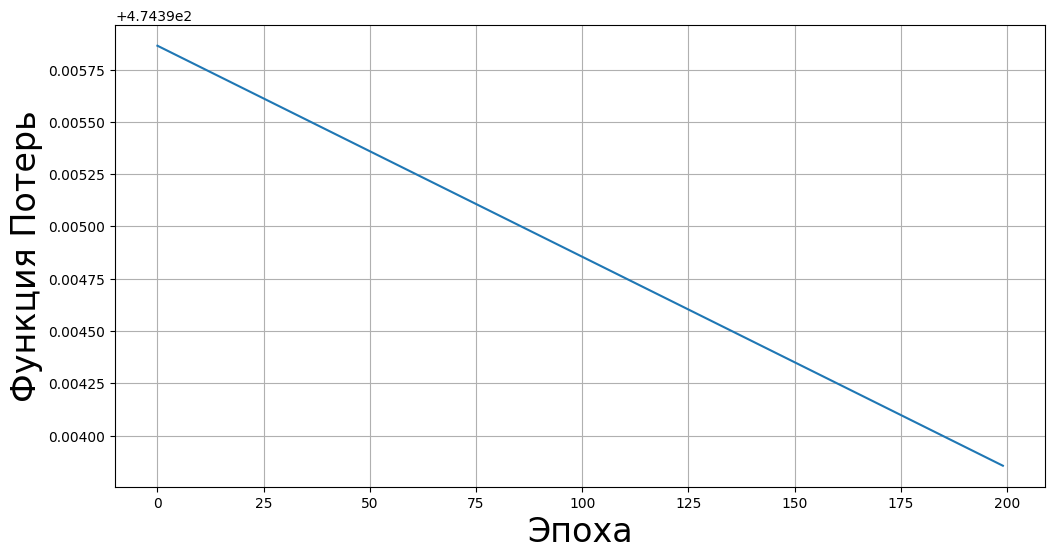

In [62]:
lin_reg_model = LinearRegression(X=x_train, learning_rate=0.00000000001, epochs=200, batch_size=8)
lin_reg_model.fit(x_train, y_train)
lin_reg_model.plot_cost()
min_cost = min(lin_reg_model.cost)
r3 = lin_reg_model.score(x_train, y_train)
best_weights = lin_reg_model.weights
best_epoch = int(np.where(lin_reg_model.cost == min_cost)[0][0])

In [63]:
r3

np.float64(-2.365761201127872)

In [64]:
best_epoch

199